## `dq_init` step

The Data Quality (DQ) initialization step populates the DQ mask for the input dataset. Flags are obtained from the mask reference files in CRDS are copied into the PIXELDQ array of the input dataset. The PIXELDQ array flags issues with pixels such as bad pixels, hot pixels, etc.

Official documentation for `dq_init` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/dq_init/index.html>


### Input data

An example of running the `dq_init` step is now shown using a simple simulated observation of a galaxy with the MIRI Imager (F1130W filter) produced with [MIRISim v2.3](https://wiki.miricle.org/Public/MIRISim_Public).

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [1]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from jwst import datamodels

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0641.pmap"

Import `dq_init` and print the docstring and spec to show some information

In [2]:
# import the step
from jwst.dq_init import dq_init_step

# print the description and options
print(dq_init_step.DQInitStep.__doc__)
print(dq_init_step.DQInitStep.spec)


Initialize the Data Quality extension from the
    mask reference file.

    The dq_init step initializes the pixeldq attribute of the
    input datamodel using the MASK reference file.  For some
    FGS exp_types, initalize the dq attribute of the input model
    instead.  The dq attribute of the MASK model is bitwise OR'd
    with the pixeldq (or dq) attribute of the input model.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip           

Set the name of the input file and run the step. This will produce an output file ending with `_dqinitstep.fits`.

*Parameters used:*

`output_use_model` : boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; propagate the input filename to the output
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file

Note that the `dq_init` will return the output datamodel so we set this to the `dm` variable.


In [3]:
# user specified
my_input_file = 'det_image_seq1_MIRIMAGE_F1130Wexp1.fits'

# run the step
dm = dq_init_step.DQInitStep.call(my_input_file, output_use_model=True, save_results=True)


2020-10-29 13:58:06,525 - stpipe - WARNING - /Users/patrickkavanagh/anaconda3/anaconda3/envs/jwst7.6/lib/python3.8/site-packages/jwst/datamodels/util.py:185: NoTypeWarning: model_type not found. Opening det_image_seq1_MIRIMAGE_F1130Wexp1.fits as a RampModel
  warnings.warn(f"model_type not found. Opening {file_name} as a {class_name}",

2020-10-29 13:58:08,887 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   Unknown reference type 'pars-dqinitstep'
2020-10-29 13:58:08,889 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2020-10-29 13:58:08,962 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('det_image_seq1_MIRIMAGE_F1130Wexp1.fits',).
2020-10-29 13:58:08,964 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_outpu

We can plot the science image and the PIXELDQ array, now with flags from the mask reference file. Note that if the PIXELDQ array does not exist it will be created. In the case of MIRISim data, the PIXELDQ array does already exist and the flags are already correct since these are populated by the simulator using the CDPs. In this case, the pipeline is overwriting the PIXELDQ array with the same array!

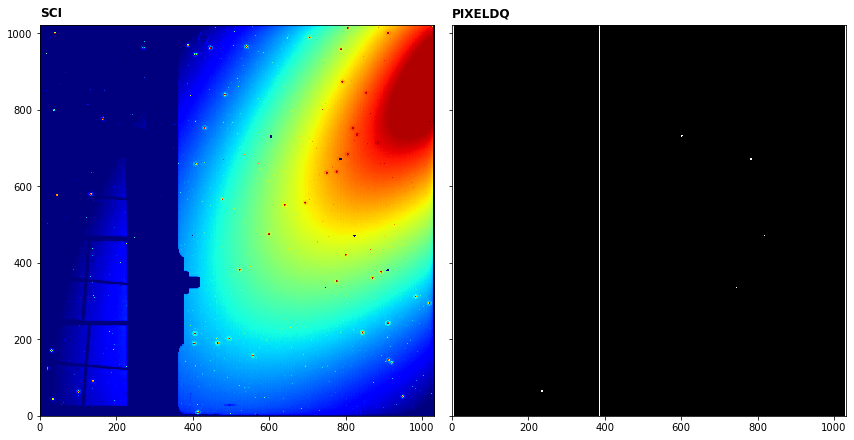

In [4]:
# plot the science and pixeldq arrays
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# show last frame of first integration
axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1.1e4,vmax=6.5e4))
axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# plot the PIXEL_DQ frame
axs[1].imshow(dm.pixeldq, cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
axs[1].annotate('PIXELDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### Command line

To achieve the same result from the command line there are a couple of options. 

**Option 1:**
Run the `DQInitStep` class using the `strun` command:

```bash
strun jwst.dq_init.DQInitStep det_image_seq1_MIRIMAGE_F1130Wexp1.fits
```

**Option 2:**
If they don't already exist, collect the pipeline configuration files in your working directory using `collect_pipeline_configs` and then run the `DQInitStep` using the `strun` command with the associated `dq_init.cfg` file. 

```bash
collect_pipeline_cfgs cfgs/

strun cfgs/dq_init.cfg det_image_seq1_MIRIMAGE_F1130Wexp1.fits
```

This will produce the same output file ending with `_dqinitstep.fits` 


A full list of the command line options are given by running the following:


```bash
strun jwst.dq_init.DQInitStep -h
```

or 

```bash
strun cfgs/dq_init.cfg -h
```



### Override reference file

To override the reference file for this step in Python:

```python
# set the override reference file name
my_ref = 'my_mask.fits'

dm = dq_init_step.DQInitStep.call(my_input_file, output_use_model=True, save_results=True,
                                 override_mask=my_ref)
```

and using the command line:

```bash
strun jwst.dq_init.DQInitStep det_image_seq1_MIRIMAGE_F1130Wexp1.fits  --override_mask my_mask.fits
```

or

```bash
strun cfgs/dq_init.cfg det_image_seq1_MIRIMAGE_F1130Wexp1.fits --override_mask my_mask.fits
```